## 1. Smooth solvers

ODL also has a number of numerical solvers for smooth problems, most of them first-order methods, i.e., methods that involve the gradient of the cost function. The [LBFGS](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/smooth/newton.py#L247-L487) method is the limited memory variant of the popular [BFGS algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) for smooth optimization.

Use it to solve the smoothed variant

$$
    \min_{x} \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_{1, \epsilon} \right]
$$

of the TV denoising problem, where $\|\cdot\|_{1, \epsilon}$ is the [Huber function](https://en.wikipedia.org/wiki/Huber_loss)

$$
    \|x\|_{1, \epsilon} = \int \left|x(t)\right|_\epsilon\, \mathrm{d} t, \\
    |u|_\epsilon =
    \begin{cases}
        \frac{1}{2\epsilon} |u|_2^2,  & \text{if } |u| \leq \epsilon, \\
        |u| - \frac{\epsilon}{2},     & \text{if } |u| > \epsilon.
    \end{cases}
$$

It is a smoothed variant of the 1-norm that is differentiable everywhere. 

### Tasks

- Set up the smooth version of the TV minimization problem using the Huber function.
- Solve it with a smooth solver, using, e.g., BFGS.

### Good to know

- You may think that this is a lot of work. It isn't! That's because the Huber function is the **Moreau envelope** of the 1-norm. You don't need to know what this means exactly -- the important property that you will apply is

  $$
      \nabla \|\cdot\|_{1, \epsilon}(x) = \frac{1}{\epsilon}\left( x - \mathrm{prox}_{\epsilon \|.\|_1}(x) \right),
  $$
  
  i.e., the gradient can be computed using the proximal operator of the 1-norm. Conveniently, there is the [`odl.solvers.MoreauEnvelope`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/functional/default_functionals.py#L2204-L2292) class that implements this property for you (find out how to use it).
  
- The above holds for any convex function. For the Huber function, there is even an optimized implementation that you can use.

- For the smooth solvers, you need to combine everything into a single function, including adding the functions and composing them with linear operators.

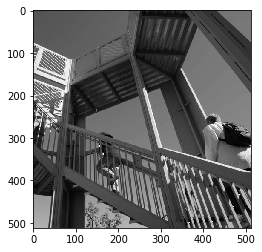

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.misc
import odl
import numpy as np 

image = scipy.misc.ascent().astype('float32')
plt.imshow(image, cmap='gray')


In [6]:
shape = image.T.shape
X = odl.uniform_discr((0, 0), shape, shape)
X.cell_sides

array([ 1.,  1.])

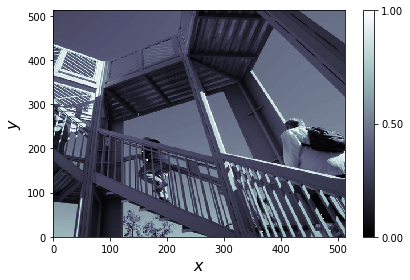

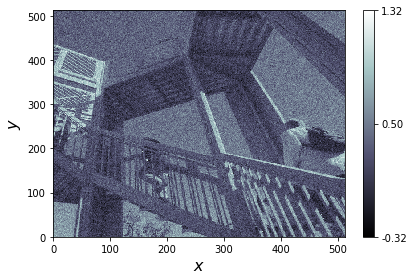

In [16]:
image /= image.max()
x_true = X.element(np.rot90(image, -1))
_ = x_true.show()

with odl.util.NumpyRandomSeed(123):
    y = x_true + 0.1 * odl.phantom.white_noise(X)
    
_ = y.show()    

In [57]:
grad = odl.Gradient(X)


alpha = 0.15
total = odl.solvers.L2Norm(X).translated(y) + odl.solvers.Huber(grad.range, gamma=1) * grad


In [37]:
total((X.zero())) # check that we can compose the functions

207.58436508465641

In [129]:
x = X.zero()
odl.solvers.bfgs_method(total, x, maxiter=300)

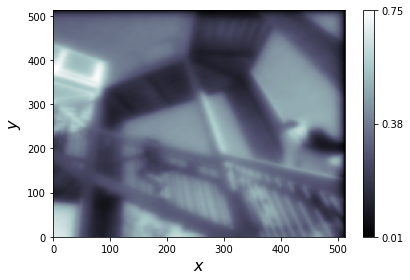

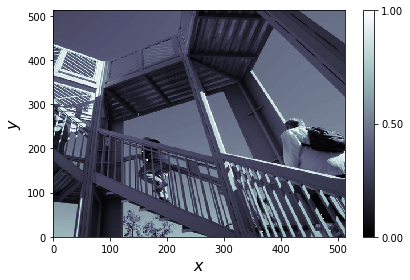

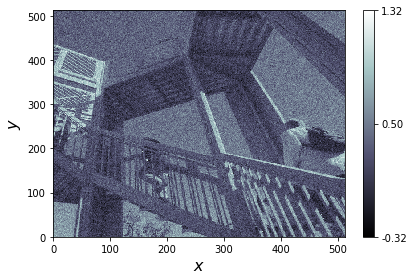

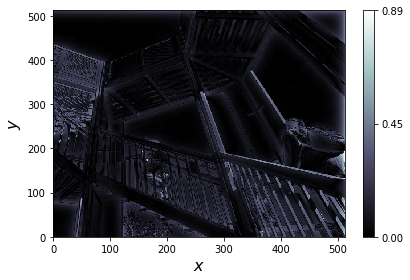

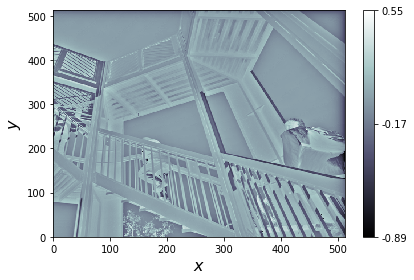

In [59]:
_ = x.show()
_ = x_true.show()
_ = y.show()
_ = np.abs(x_true - x).show()
_ = (x - x_true).show()

In [114]:
grad = odl.Gradient(X)

I = odl.IdentityOperator(X)
L = odl.BroadcastOperator(I, grad)

L_norm = 1.1 * odl.power_method_opnorm(L, xstart=x, maxiter=20)

tau = 1.0 / L_norm
sigma = 1.0 / L_norm

print('||L|| =', L_norm)

||L|| = 3.20667031676


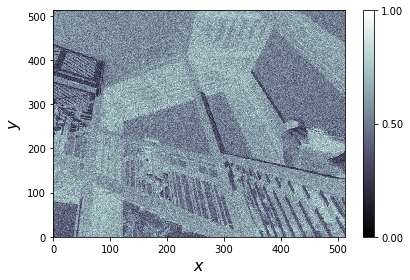

In [117]:
#intensity = np.float(1e3)
with odl.util.NumpyRandomSeed(123):
    y = odl.phantom.poisson_noise(1000 - 200 * x_true)
    y -= np.min(y)
    y /= np.max(y)
_ = y.show()
f1 = odl.solvers.KullbackLeibler(space=X, prior=y)
f1 = odl.solvers.L1Norm(X).translated(y)
f2 = odl.solvers.L1Norm(grad.range)
f = odl.solvers.SeparableSum(f1, f2)
g = odl.solvers.IndicatorNonnegativity(X)
alpha = 0.15

x = X.one()
odl.solvers.pdhg(x, f, g, L, tau, sigma, 200)

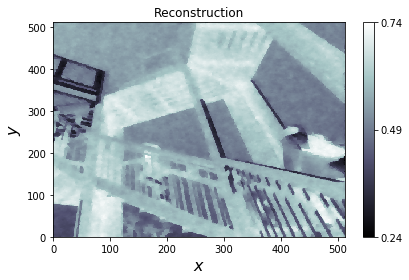

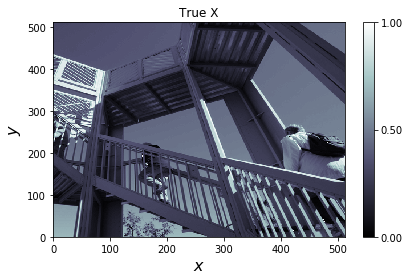

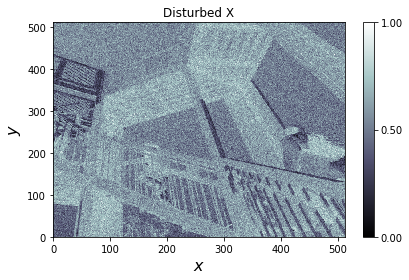

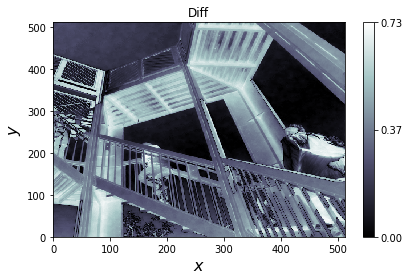

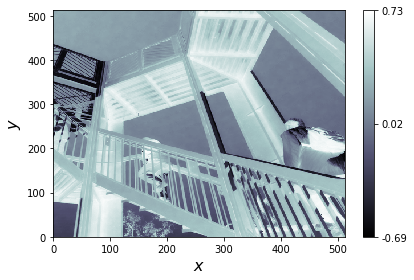

In [118]:
_ = x.show('Reconstruction')
_ = x_true.show('True X')
_ = y.show('Disturbed X')
_ = np.abs(x_true - x).show('Diff')
_ = (x - x_true).show()

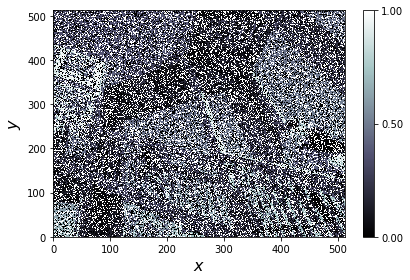

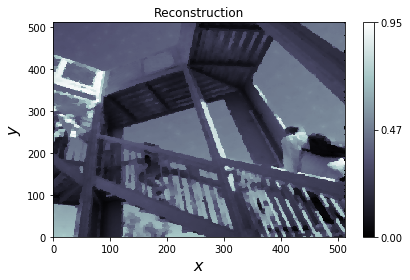

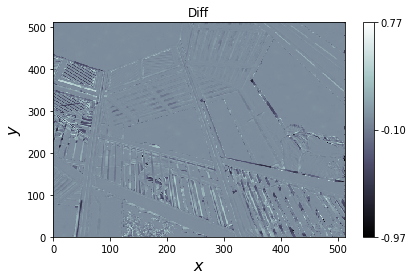

In [146]:
#intensity = np.float(1e3)
with odl.util.NumpyRandomSeed(123):
    y = odl.phantom.salt_pepper_noise(x_true, 0.5)
    
_ = y.show()
# f1 = odl.solvers.KullbackLeibler(space=X, prior=y)
f1 = odl.solvers.L1Norm(X).translated(y)
f2 = odl.solvers.L1Norm(grad.range)
f = odl.solvers.SeparableSum(f1, f2)
g = odl.solvers.IndicatorNonnegativity(X)
alpha = 0.10

x = X.one()
odl.solvers.pdhg(x, f, g, L, tau, sigma, 200)
_ = x.show('Reconstruction')
_ = (x - x_true).show('Diff')

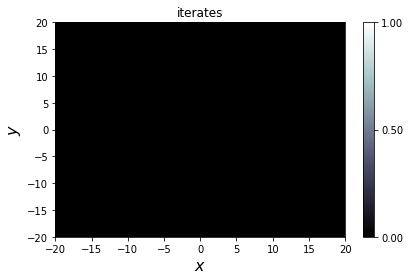

iter = 0
iter = 1
iter = 2
iter = 3
iter = 4


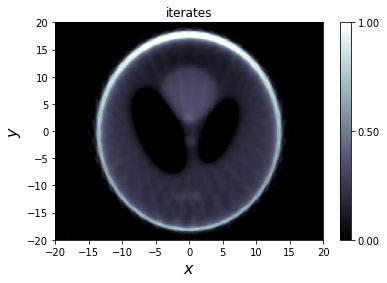

iter = 5
iter = 6
iter = 7
iter = 8
iter = 9


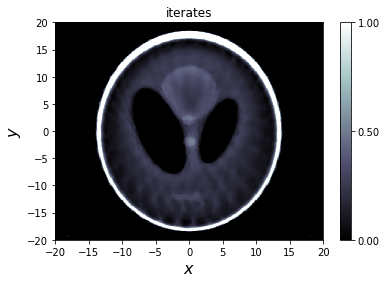

iter = 10
iter = 11
iter = 12
iter = 13
iter = 14


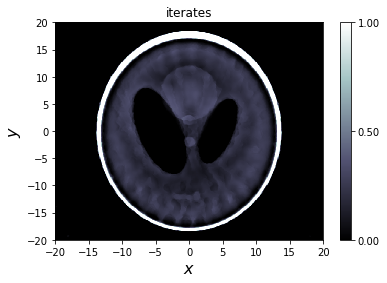

iter = 15
iter = 16
iter = 17
iter = 18
iter = 19


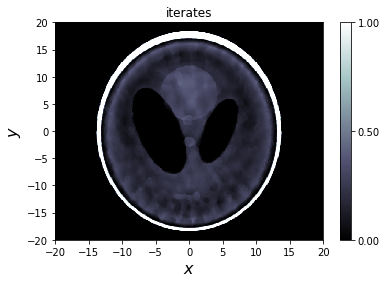

iter = 20
iter = 21
iter = 22
iter = 23
iter = 24


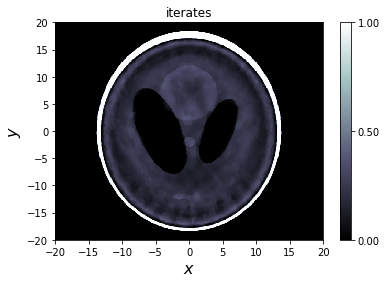

iter = 25
iter = 26
iter = 27
iter = 28
iter = 29


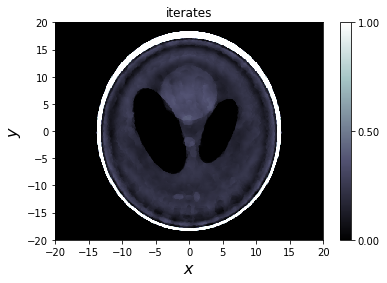

iter = 30
iter = 31
iter = 32
iter = 33
iter = 34


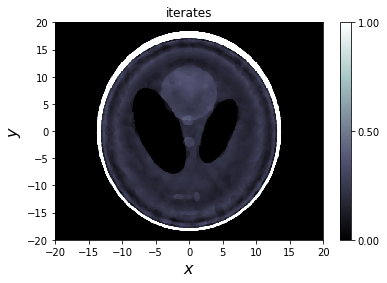

iter = 35
iter = 36
iter = 37
iter = 38
iter = 39


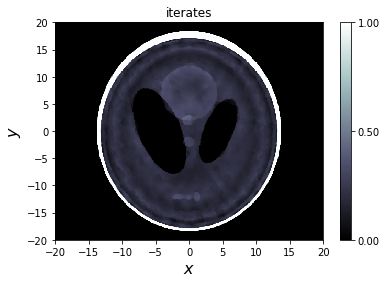

iter = 40
iter = 41
iter = 42
iter = 43
iter = 44


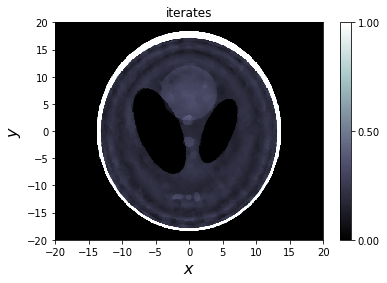

iter = 45
iter = 46
iter = 47
iter = 48
iter = 49


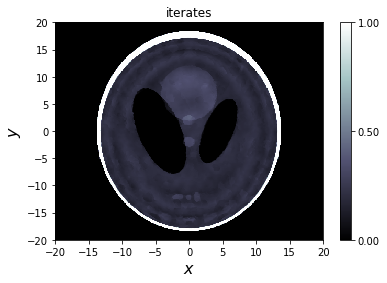

iter = 50
iter = 51
iter = 52
iter = 53
iter = 54


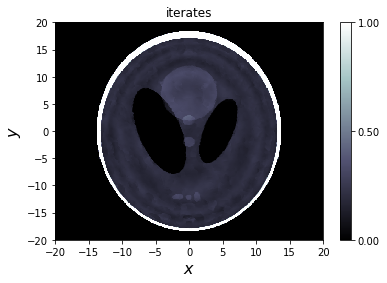

iter = 55
iter = 56
iter = 57
iter = 58
iter = 59


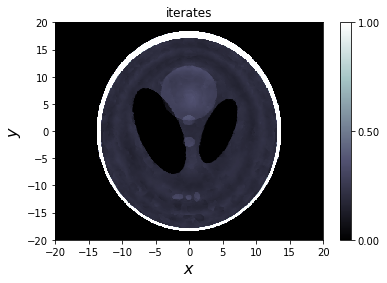

iter = 60
iter = 61
iter = 62
iter = 63
iter = 64


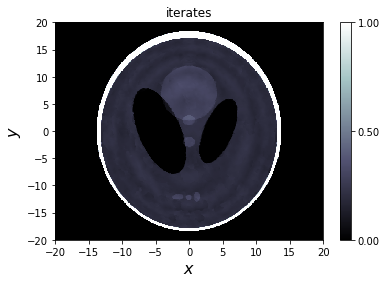

iter = 65
iter = 66
iter = 67
iter = 68
iter = 69


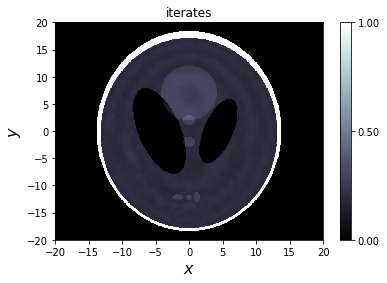

iter = 70
iter = 71
iter = 72
iter = 73
iter = 74


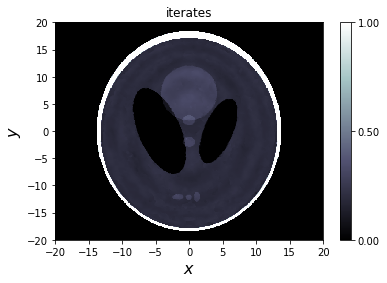

iter = 75
iter = 76
iter = 77
iter = 78
iter = 79


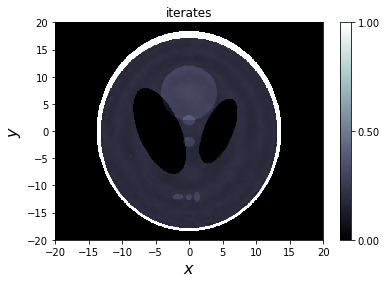

iter = 80
iter = 81
iter = 82
iter = 83
iter = 84


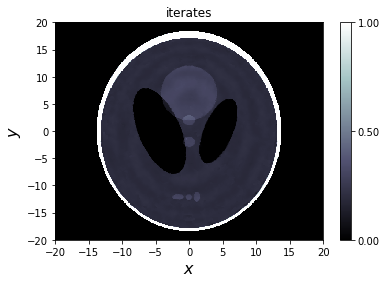

iter = 85
iter = 86
iter = 87
iter = 88
iter = 89


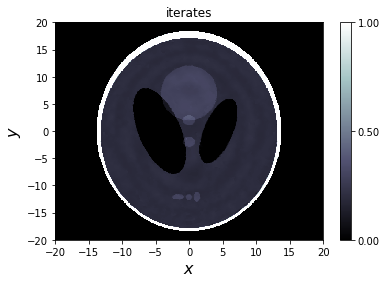

iter = 90
iter = 91
iter = 92
iter = 93
iter = 94


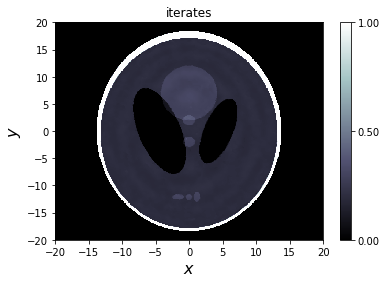

iter = 95
iter = 96
iter = 97
iter = 98
iter = 99


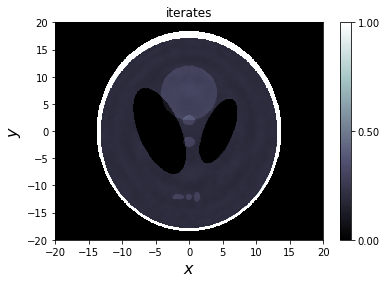

iter = 100
iter = 101
iter = 102
iter = 103
iter = 104


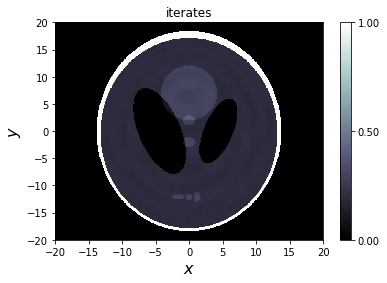

iter = 105
iter = 106
iter = 107
iter = 108
iter = 109


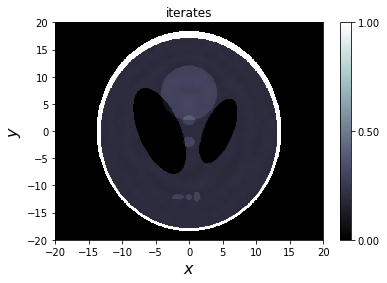

iter = 110
iter = 111
iter = 112
iter = 113
iter = 114


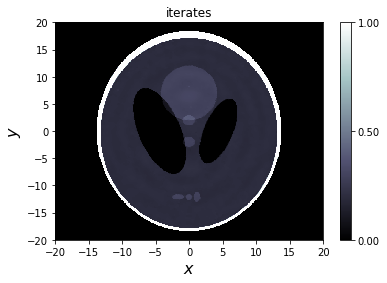

iter = 115
iter = 116
iter = 117
iter = 118
iter = 119


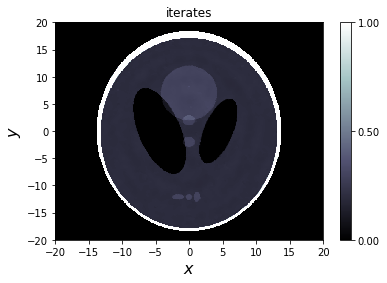

iter = 120
iter = 121
iter = 122
iter = 123
iter = 124


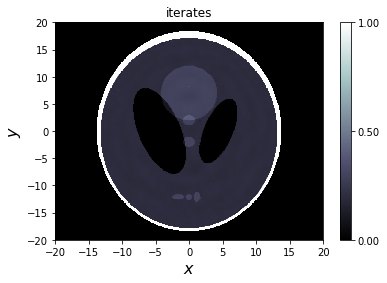

iter = 125
iter = 126
iter = 127
iter = 128
iter = 129


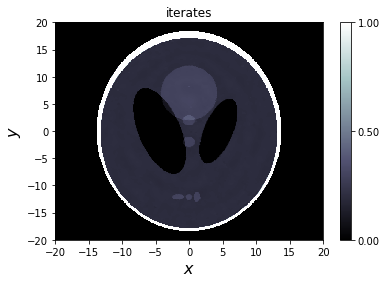

iter = 130
iter = 131
iter = 132
iter = 133
iter = 134


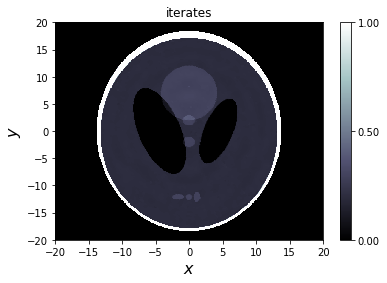

iter = 135
iter = 136
iter = 137
iter = 138
iter = 139


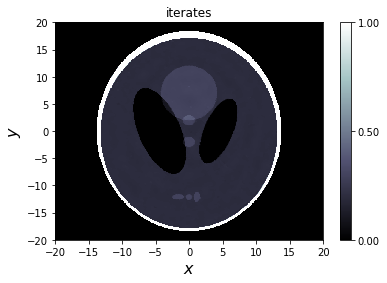

iter = 140
iter = 141
iter = 142
iter = 143
iter = 144


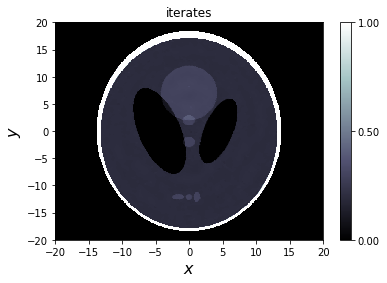

iter = 145
iter = 146
iter = 147
iter = 148
iter = 149


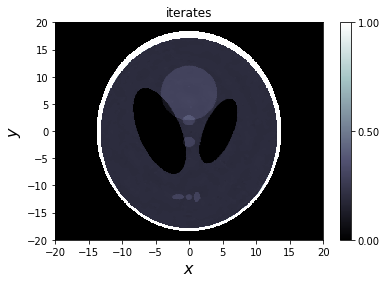

iter = 150
iter = 151
iter = 152
iter = 153
iter = 154


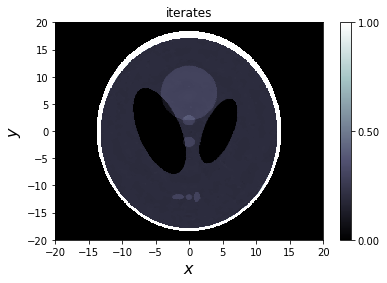

iter = 155
iter = 156
iter = 157
iter = 158
iter = 159


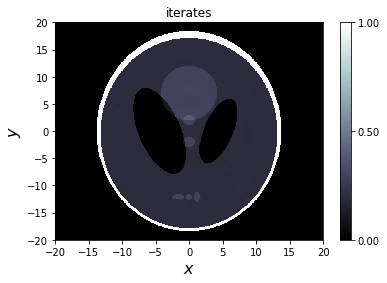

iter = 160
iter = 161
iter = 162
iter = 163
iter = 164


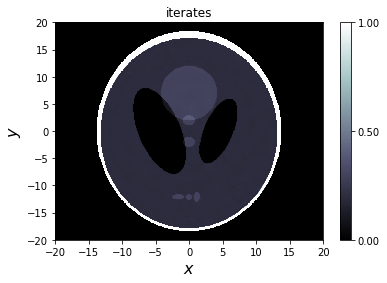

iter = 165
iter = 166
iter = 167
iter = 168
iter = 169


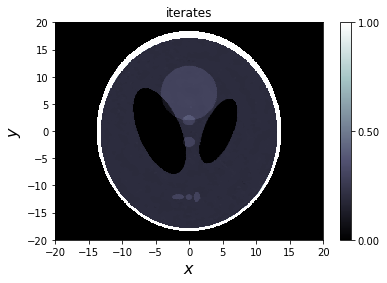

iter = 170
iter = 171
iter = 172
iter = 173
iter = 174


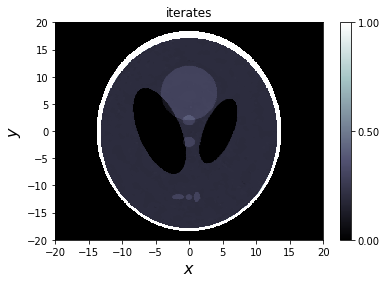

iter = 175
iter = 176
iter = 177
iter = 178
iter = 179


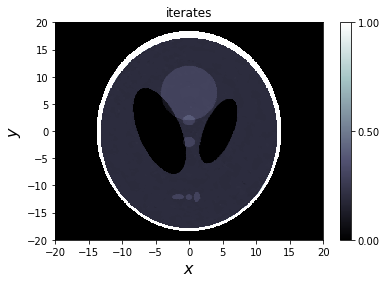

iter = 180
iter = 181
iter = 182
iter = 183
iter = 184


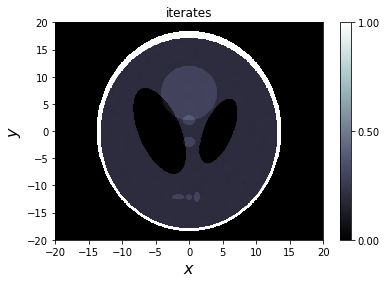

iter = 185
iter = 186
iter = 187
iter = 188
iter = 189


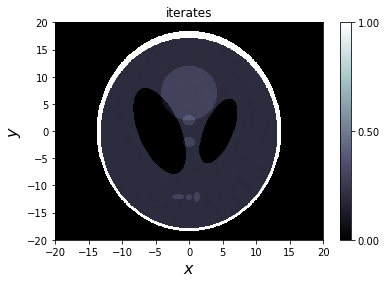

iter = 190
iter = 191
iter = 192
iter = 193
iter = 194


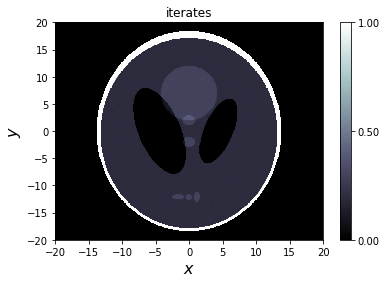

iter = 195
iter = 196
iter = 197
iter = 198
iter = 199


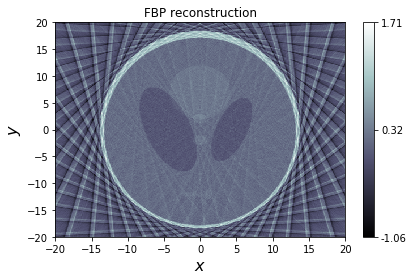

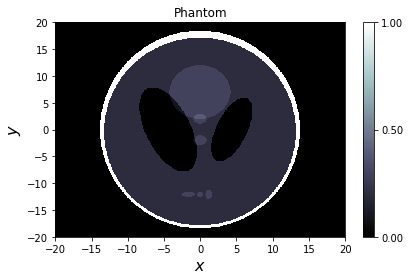

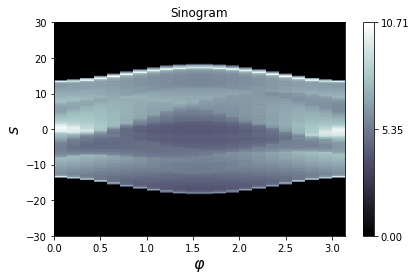

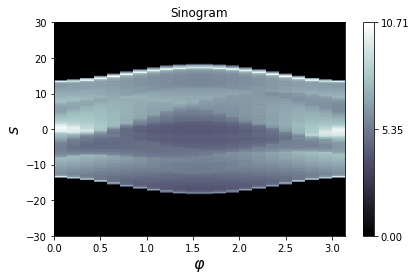

In [147]:
"""Total variation sparse angle tomography using the Douglas-Rachford solver.

Solves the optimization problem

    min_{0 <= x <= 1, Ax = g} lam ||grad(x)||_x

where ``A`` is ray transform operator, ``g`` the given noisy data, ``grad`` is
the spatial gradient and || . ||_x is the so called cross-norm, giving rise to
isotropic Total Variation.

This problem can be rewritten in the form

    min_{0 <= x <= 1} lam ||grad(x)||_x + I_{Ax = g}

where I_{.} is the indicator function, which is zero if ``Ax = g`` and infinity
otherwise. This is a standard convex optimization problem that can
be solved with the `douglas_rachford_pd` solver.

In this example, the problem is solved with only 22 angles available, which is
highly under-sampled data. Despite this, we get a perfect reconstruction.
A filtered back-projection (pseudoinverse) reconstruction is also shown at the
end for comparsion.

This is an implementation of the "puzzling numerical experiment" in the seminal
paper "Robust Uncertainty Principles: Exact Signal Reconstruction from Highly
Incomplete Frequency Information", Candes et. al. 2006.

Note that the ``Ax = g`` condition can be relaxed to ``||Ax - g|| <= eps``
for some small ``eps`` in order to account for noise. This can be done using
the `IndicatorLpUnitBall` functional instead of `IndicatorZero`.
"""

import numpy as np
import odl

# Parameters
lam = 0.01
data_matching = 'exact'

# --- Create spaces, forward operator and simulated data ---

# Reconstruction space: discretized functions on the rectangle
# [-20, 20]^2 with 512 samples per dimension.
space = odl.uniform_discr(min_pt=[-20, -20], max_pt=[20, 20], shape=[512, 512])

# Make a parallel beam geometry with flat detector
# Angles: uniformly spaced, n = 22, min = 0, max = pi
angle_partition = odl.uniform_partition(0, np.pi, 22)
# Detector: uniformly sampled, n = 512, min = -30, max = 30
detector_partition = odl.uniform_partition(-30, 30, 512)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(space, geometry)

# Create sinogram
phantom = odl.phantom.shepp_logan(space, modified=True)
data = ray_trafo(phantom)

# --- Create functionals for solving the optimization problem ---

# Gradient for TV regularization
gradient = odl.Gradient(space)

# Functional to enforce 0 <= x <= 1
f = odl.solvers.IndicatorBox(space, 0, 1)

if data_matching == 'exact':
    # Functional to enforce Ax = g
    # Due to the splitting used in the douglas_rachford_pd solver, we only
    # create the functional for the indicator function on g here, the forward
    # model is handled separately.
    indicator_zero = odl.solvers.IndicatorZero(ray_trafo.range)
    indicator_data = indicator_zero.translated(data)
elif data_matching == 'inexact':
    # Functional to enforce ||Ax - g||_2 < eps
    # We do this by rewriting the condition on the form
    # f(x) = 0 if ||A(x/eps) - (g/eps)||_2 < 1, infinity otherwise
    # That function (with A handled separately, as mentioned above) is
    # implemented in ODL as the IndicatorLpUnitBall function.
    # Note that we use right multiplication in order to scale in input argument
    # instead of the result of the functional, as would be the case with left
    # multiplication.
    eps = 5.0

    # Add noise to data
    raw_noise = odl.phantom.white_noise(ray_trafo.range)
    data += raw_noise * eps / raw_noise.norm()

    # Create indicator
    indicator_l2_ball = odl.solvers.IndicatorLpUnitBall(ray_trafo.range, 2)
    indicator_data = indicator_l2_ball.translated(data / eps) * (1 / eps)
else:
    raise RuntimeError('unknown data_matching')

# Functional for TV minimization
cross_norm = lam * odl.solvers.GroupL1Norm(gradient.range)

# --- Create functionals for solving the optimization problem ---

# Assemble operators and functionals for the solver
lin_ops = [ray_trafo, gradient]
g = [indicator_data, cross_norm]

# Create callback that prints the iteration number and shows partial results
callback = (odl.solvers.CallbackShow('iterates', step=5, clim=[0, 1]) &
            odl.solvers.CallbackPrintIteration())

# Solve with initial guess x = 0.
# Step size parameters are selected to ensure convergence.
# See douglas_rachford_pd doc for more information.
x = ray_trafo.domain.zero()
odl.solvers.douglas_rachford_pd(x, f, g, lin_ops,
                                tau=0.1, sigma=[0.1, 0.02], lam=1.5,
                                niter=200, callback=callback)

# Compare with filtered back-projection
fbp_recon = odl.tomo.fbp_op(ray_trafo)(data)
fbp_recon.show('FBP reconstruction')
phantom.show('Phantom')
data.show('Sinogram', force_show=True)
